# Homework 04 - Applied ML

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
%matplotlib inline

## 1. Predict the skin color of a soccer player

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

### 1.1 Exploratory Data Analysis, Feature Selection and Feature engineering

In [2]:
# Import data 
data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep = ',')

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

##### First clean of data
According to the given information in the [data description](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md), we get rid off all the dyads that correspond to players whose picture is not available.

In [5]:
data_clean = data[(data.photoID.notnull()) | (data.photoID.notnull())]

##### Have a glance at the labels

Thus, we check whether happens that one of the two raters do not assign the label. We see that both of them do their job. 

In [6]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


In [ ]:
data_clean['playerShort']

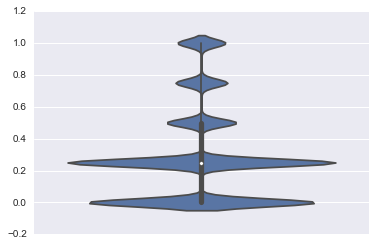

In [26]:
sns.violinplot([data_clean.rater1, data_clean.rater2], orient= 'v')

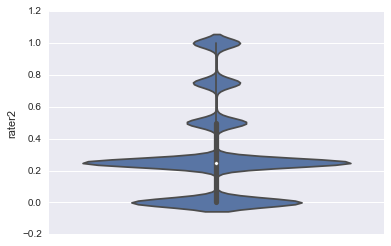

In [27]:
sns.violinplot(data_clean.rater2, orient= 'v')

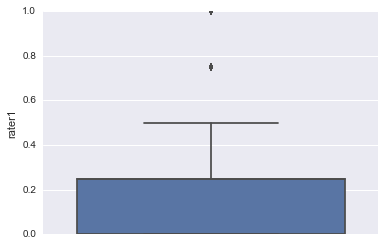

In [24]:
sns.boxplot(data_clean.rater1, orient = 'v')

In [32]:
data_clean[data_clean['rater1'] != data_clean['rater2']][['rater1', 'rater2']]

,rater1,rater2
0,0.25,0.50
5,0.25,0.00
6,0.00,0.25
14,0.00,0.25
19,0.00,0.25
20,0.00,0.25
24,0.25,0.00
26,0.00,0.25
27,0.00,0.25
29,0.00,0.25
